In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import minmax_scale
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras
import h5py as h5py
import cython

Using TensorFlow backend.


In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [11]:
sp500 = pd.DataFrame(data=web.DataReader('SP500', 'fred', start='2010', end='2020').dropna())
sp500.info()
sp500_scaled = sp500.apply(minmax_scale)
sp500_scaled

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2492 entries, 2010-02-08 to 2019-12-31
Data columns (total 1 columns):
SP500    2492 non-null float64
dtypes: float64(1)
memory usage: 38.9 KB


,SP500
DATE,
2010-02-08,0.015405
2010-02-09,0.021620
2010-02-10,0.020542
2010-02-11,0.025205
2010-02-12,0.023870
...,...
2019-12-24,0.992496
2019-12-26,0.999950
2019-12-27,1.000000


In [12]:
def create_univariate_rnn_data(data, window_size):
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    n = data.shape[0]
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [13]:
window_size = 63

In [14]:
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

In [15]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
DATE,,,,,,,,,,,,,,,,,,,,,
2010-05-10,0.015405,0.021620,0.020542,0.025205,0.023870,0.032601,0.034693,0.037958,0.039050,0.038526,...,0.085445,0.072665,0.076115,0.083069,0.074009,0.081030,0.068106,0.064633,0.047609,0.039821
2010-05-11,0.021620,0.020542,0.025205,0.023870,0.032601,0.034693,0.037958,0.039050,0.038526,0.032479,...,0.072665,0.076115,0.083069,0.074009,0.081030,0.068106,0.064633,0.047609,0.039821,0.061851
2010-05-12,0.020542,0.025205,0.023870,0.032601,0.034693,0.037958,0.039050,0.038526,0.032479,0.037277,...,0.076115,0.083069,0.074009,0.081030,0.068106,0.064633,0.047609,0.039821,0.061851,0.060074
2010-05-13,0.025205,0.023870,0.032601,0.034693,0.037958,0.039050,0.038526,0.032479,0.037277,0.036240,...,0.083069,0.074009,0.081030,0.068106,0.064633,0.047609,0.039821,0.061851,0.060074,0.067235
2010-05-14,0.023870,0.032601,0.034693,0.037958,0.039050,0.038526,0.032479,0.037277,0.036240,0.036939,...,0.074009,0.081030,0.068106,0.064633,0.047609,0.039821,0.061851,0.060074,0.067235,0.060818


In [21]:
X_train = X[:'2018'].values.reshape(-1, window_size, 1)
y_train = y[:'2018']

# keep the last year for testing
X_test = X['2019'].values.reshape(-1, window_size, 1)
y_test = y['2019']

In [22]:
X_train.shape

(2177, 63, 1)

In [23]:
n_obs, window_size, n_features = X_train.shape

In [24]:
rnn = Sequential([
    LSTM(units=20, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

In [25]:
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 20)                1760      
_________________________________________________________________
Output (Dense)               (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [30]:
optimizer = keras.optimizers.RMSprop(lr=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

In [31]:
rnn.compile(loss='mean_squared_error', optimizer=optimizer)

In [35]:
rnn_path = 'D:\Stanford\CS230\Project\sp500.hdf5'
checkpointer = ModelCheckpoint(filepath=rnn_path,
                              monitor='val_loss',
                              save_best_only=True,
                              save_weights_only=True,
                              period=5)

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=25,
                              restore_best_weights=True)

In [37]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=200,
                 batch_size=20,
                 validation_data=(X_test, y_test),
                 callbacks=[checkpointer, early_stopping],
                 verbose=1)

Train on 2177 samples, validate on 252 samples
Epoch 1/200
2177/2177 [==============================] - 4s 2ms/step - loss: 1.9692e-04 - val_loss: 1.9017e-04
Epoch 2/200
2177/2177 [==============================] - 5s 2ms/step - loss: 1.9009e-04 - val_loss: 4.9261e-04
Epoch 3/200
2177/2177 [==============================] - 4s 2ms/step - loss: 1.7664e-04 - val_loss: 1.4125e-04
Epoch 4/200
2177/2177 [==============================] - 4s 2ms/step - loss: 1.6684e-04 - val_loss: 3.0667e-04
Epoch 5/200
2177/2177 [==============================] - 4s 2ms/step - loss: 1.5710e-04 - val_loss: 2.1653e-04
Epoch 6/200
2177/2177 [==============================] - 4s 2ms/step - loss: 1.5433e-04 - val_loss: 1.9176e-04
Epoch 7/200
2177/2177 [==============================] - 4s 2ms/step - loss: 1.4476e-04 - val_loss: 0.0010
Epoch 8/200
2177/2177 [==============================] - 4s 2ms/step - loss: 1.4867e-04 - val_loss: 1.2448e-04
Epoch 9/200
2177/2177 [==============================] - 4s 2ms/step 

In [ ]:
#rnn.load_weights(rnn_path)

In [47]:
def eval_result():
    test_predict = pd.Series(rnn.predict(X_test).squeeze(), index=y_test.index)
    train_predict = pd.Series(rnn.predict(X_train).squeeze(), index=y_train.index)
    rmse = np.sqrt(mean_squared_error(test_predict, y_test))
    return test_predict, train_predict, rmse

In [48]:
test_predict, train_predict, rmse = eval_result()

In [49]:
test_predict

DATE
2019-01-02    0.672764
2019-01-03    0.674150
2019-01-04    0.645617
2019-01-07    0.683477
2019-01-08    0.690784
                ...   
2019-12-24    0.991088
2019-12-26    0.990956
2019-12-27    0.998719
2019-12-30    0.997901
2019-12-31    0.989353
Length: 252, dtype: float32

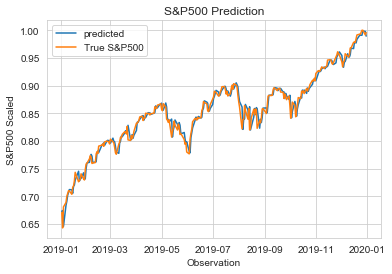

In [52]:
plt.plot(test_predict, label='predicted')
plt.plot(y_test, label = 'True S&P500')
plt.title("S&P500 Prediction")
plt.xlabel('Observation')
plt.ylabel('S&P500 Scaled')
plt.legend()
plt.show()